In [2]:
%matplotlib inline



# Exploring coherence and ITC with the LIMO dataset

Here we explore the structure of the data contained in the
`LIMO dataset`.
This example replicates and extends some of the main analysis
and tools integrated in `LIMO MEEG`, a MATLAB toolbox originally designed
to interface with EEGLAB.

In summary, the example:

- Fetches epoched data files for a single subject of the LIMO dataset [1]_.
  If the LIMO files are not found on disk, the
  fetcher :func:`mne.datasets.limo.load_data()` will automatically download
  the files from a remote repository.

- During import, information about the data (i.e., sampling rate, number of
  epochs per condition, number and name of EEG channels per subject, etc.) is
  extracted from the LIMO :file:`.mat` files stored on disk and added to the
  epochs structure as metadata.

- Plots and explores coherence as introduced by stimuli

- Investigates the ITC and Power relations contained therein

## References
.. [1] Guillaume, Rousselet. (2016). LIMO EEG Dataset, [dataset].
       University of Edinburgh, Centre for Clinical Brain Sciences.
       https://doi.org/10.7488/ds/1556.
.. [2] Rousselet, G. A., Gaspar, C. M., Pernet, C. R., Husk, J. S.,
       Bennett, P. J., & Sekuler, A. B. (2010). Healthy aging delays scalp EEG
       sensitivity to noise in a face discrimination task.
       Frontiers in psychology, 1, 19. https://doi.org/10.3389/fpsyg.2010.00019
.. [3] Rousselet, G. A., Pernet, C. R., Bennett, P. J., & Sekuler, A. B.
       (2008). Parametric study of EEG sensitivity to phase noise during face
       processing. BMC neuroscience, 9(1), 98.
       https://doi.org/10.1186/1471-2202-9-98


In [3]:
# Authors: Jose C. Garcia Alanis <alanis.jcg@gmail.com>
# AND now with edits by me: Jamie Lubell
# License: BSD (3-clause)

import numpy as np
import matplotlib.pyplot as plt
import mne

from mne.datasets.limo import load_data
from mne.stats import linear_regression
from mne.viz import plot_events, plot_compare_evokeds
from mne import combine_evoked
from mne.time_frequency import tfr_morlet, psd_multitaper, psd_welch

print(__doc__)

# subject to use
subj = 1

Automatically created module for IPython interactive environment


[id]: https://media.springernature.com/full/springer-static/image/art%3A10.1186%2F1471-2202-9-98/MediaObjects/12868_2008_Article_781_Fig1_HTML.jpg?as=webp

## About the data

In the original LIMO experiment (see [2]), participants performed a
two-alternative forced choice task, discriminating between two face stimuli.
The same two faces were used during the whole experiment,
with varying levels of noise added, making the faces more or less
discernible to the observer (see `Fig 1` in [3] for a similar approach).

![Alt text][id]

The presented faces varied across a noise-signal (or phase-coherence)
continuum spanning from 0 to 85% in increasing steps of 5%.
In other words, faces with high phase-coherence (e.g., 85%) were easy to
identify, while faces with low phase-coherence (e.g., 5%) were hard to
identify and by extension very hard to discriminate.



## Load the data

We'll begin by loading the data from subject 1 of the LIMO dataset


In [4]:
# This step can take a little while if you're loading the data for the
# first time.
limo_epochs = load_data(subject=subj)

Adding metadata with 2 columns
Replacing existing metadata with 2 columns
1055 matching events found
No baseline correction applied
0 projection items activated
0 bad epochs dropped


Note that the result of the loading process is an
:class:`mne.EpochsArray` containing the data ready to interface
with MNE-Python.



In [5]:
print(limo_epochs)

<EpochsArray |  1055 events (all good), -0.299944 - 0.499907 sec, baseline off, ~213.9 MB, data loaded, with metadata,
 'Face/A': 524
 'Face/B': 531>


## Visualize events

We can visualise the distribution of the face events contained in the
``limo_epochs`` structure. Events should appear clearly grouped, as the
epochs are ordered by condition.



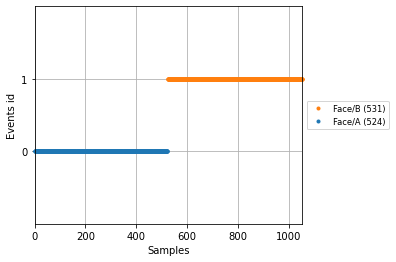

Text(0.5, 0.98, 'Distribution of events in LIMO epochs')

In [6]:
fig = plot_events(limo_epochs.events, event_id=limo_epochs.event_id)
fig.suptitle("Distribution of events in LIMO epochs")

As it can be seen above, conditions are coded as ``Face/A`` and ``Face/B``.
Information about the phase-coherence of the presented faces is stored in the
epochs metadata. These information can be easily accessed by calling
``limo_epochs.metadata``. As shown below, the epochs metadata also contains
information about the presented faces for convenience.



In [7]:
# We want include all columns in the summary table
epochs_summary = limo_epochs.metadata.describe(include='all').round(3)
print(epochs_summary)

        face  phase-coherence
count   1055         1055.000
unique     2              NaN
top        B              NaN
freq     531              NaN
mean     NaN           -0.000
std      NaN            1.000
min      NaN           -1.619
25%      NaN           -0.852
50%      NaN           -0.084
75%      NaN            0.875
max      NaN            1.642


The first column of the summary table above provides more or less the same
information as the ``print(limo_epochs)`` command. There are
1055 faces (i.e., epochs), subdivided in 2 conditions (i.e., Face A and
Face B) and, for this particular subject, there are more epochs for the
condition Face B.

In addition, we can see in the second column that the values for the
phase-coherence variable range from -1.619 to 1.642. This is because the
phase-coherence values are provided as a z-scored variable in the LIMO
dataset. Note that they have a mean of zero and a standard deviation of 1.


## Visualize condition ERPs

Before plotting the ERPs evoked by Face A and Face B,let's make an educated guess as to whether face A or face B ERPs will be different.



No projector specified for this dataset. Please consider the method self.add_proj.


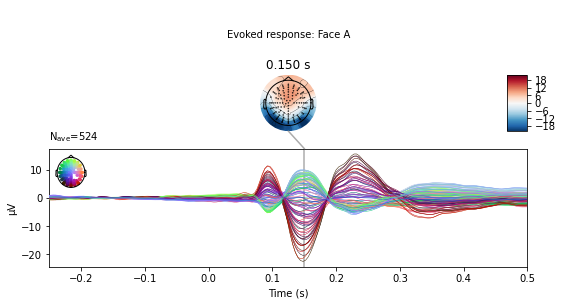

No projector specified for this dataset. Please consider the method self.add_proj.


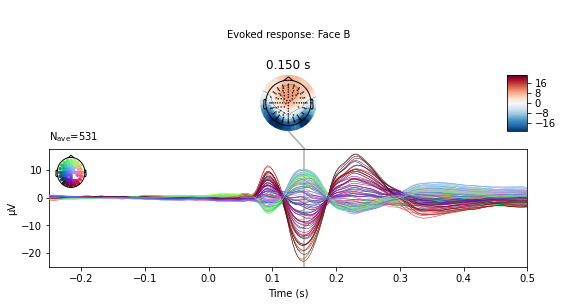

In [8]:
# only show -250 to 500 ms
ts_args = dict(xlim=(-0.25, 0.5))

# plot evoked response for face A
limo_epochs['Face/A'].average().plot_joint(times=[0.15],
                                           title='Evoked response: Face A',
                                           ts_args=ts_args);
# and face B
limo_epochs['Face/B'].average().plot_joint(times=[0.15],
                                           title='Evoked response: Face B',
                                           ts_args=ts_args);

We can also compute the difference wave contrasting Face A and Face B.
Although, looking at the evoked responses above, we shouldn't expect great
differences among these face-stimuli.



No projector specified for this dataset. Please consider the method self.add_proj.


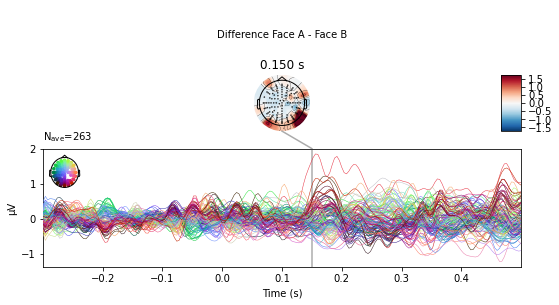

In [9]:
# Face A minus Face B
difference_wave = combine_evoked([limo_epochs['Face/A'].average(),
                                  limo_epochs['Face/B'].average()],
                                 weights=[1, -1])

# plot difference wave
difference_wave.plot_joint(times=[0.15], title='Difference Face A - Face B');

# No Dice
As expected, no clear pattern appears when contrasting
Face A and Face B. However, we could narrow our search a little bit more.
Since this is a "visual paradigm" it might be best to look at electrodes
located over the occipital lobe, as differences between stimuli (if any)
might easier to spot over visual areas.

# Hypothesis as to where a difference in the data exists?
Silly question, but relavent to what we've been talking about.


## Visualize effect of stimulus phase-coherence

Since phase-coherence
determined whether a face stimulus could be easily identified,
one could expect that faces with high phase-coherence should evoke stronger
activation patterns along occipital electrodes.



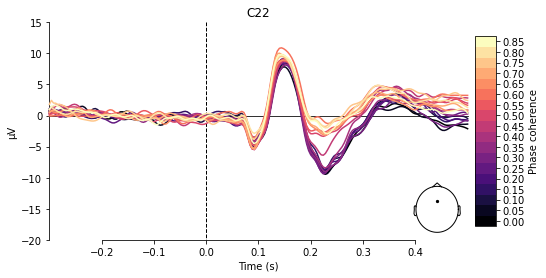

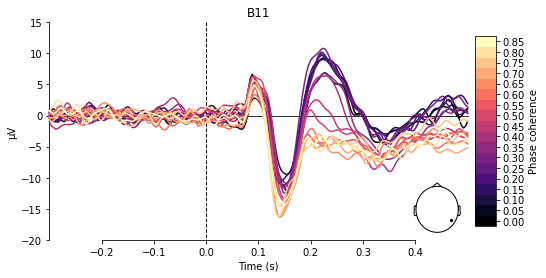

In [10]:
phase_coh = limo_epochs.metadata['phase-coherence']
# get levels of phase coherence
levels = sorted(phase_coh.unique())
# create labels for levels of phase coherence (i.e., 0 - 85%)
labels = ["{0:.2f}".format(i) for i in np.arange(0., 0.90, 0.05)]

# create dict of evokeds for each level of phase-coherence
evokeds = {label: limo_epochs[phase_coh == level].average()
           for level, label in zip(levels, labels)}

# pick channel to plot
electrodes = ['C22', 'B11']
# create figures
for electrode in electrodes:
    fig, ax = plt.subplots(figsize=(8, 4))
    plot_compare_evokeds(evokeds,
                         axes=ax,
                         ylim=dict(eeg=(-20, 15)),
                         picks=electrode,
                         cmap=("Phase coherence", "magma"))

# Describe
While inspecting the difference between these plots let's describe the differences between them.
- polarity: polarity is flipped. 
- location: 
- variance: more in B11
- spread: less discernible more amplitude (response inhibition). 
- timing: pretty much the same.

# WHY
Give me some ideas as to why stimuli coherence would produce plots like this
Think about the underlying mechanisms that might be driving this
What neuronal populations does EEG and MEEG mainly capture.
Is there a better way to visual demonstrate (describe) what's going on here?

# Power & ITC
Having determined that there is no real difference between the the conditions Face A and Face B, and that the real difference depends on the amount of phase coherence of the stimuli, we can continue exploring the effect of PC in the data but now with power and ITC.  Crucially, we mustn't worry about A and B faces anymore and can collapse those conditions.

First let's take a look at the spatial distributions of the PSD and get an idea for the terrain.

For reference, I used the exact same code from last week's practical with only a couple of tweaks.  This is a good example of how building well documented and clear code can be repurposed for further projects etc.  Don't work twice as hard on stuff you've already done.

In [11]:
# look at certain bands and at the extremes of PC, I dropped gamma because it's not relevant
bands = [(0, 4, 'Delta'), (4, 8, 'Theta'), (8, 12, 'Alpha'),
                 (12, 30, 'Beta')] # no gamma. 

    Using multitaper spectrum estimation with 7 DPSS windows


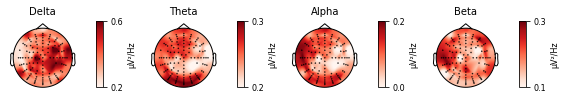

    Using multitaper spectrum estimation with 7 DPSS windows


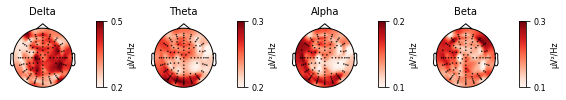

In [12]:
# What does levels[0] and levels[-1] give us?
# using Welsch again. 
# 0 = least coherent, -1 = most coherent (or opposite). 
# not a lot of interest here. 
limo_epochs[phase_coh == levels[0]].plot_psd_topomap(bands=bands, ch_type='eeg',
                                                     normalize=True);
limo_epochs[phase_coh == levels[-1]].plot_psd_topomap(bands=bands, ch_type='eeg',
                                                      normalize=True);

# Describe
Anything interesting in comparing the different types of stimuli coherence in the psd bands as we've defined them?

Let's continue on and look at power and intertrial phase coherence

In [13]:
# define frequencies of interest (log-spaced): extract power and ITC
picks = mne.pick_types(limo_epochs.info, meg=False, eeg=True, eog=False, stim=False)
freqs = np.logspace(*np.log10([6, 35]), num=8)
n_cycles = freqs / 2.  # different number of cycle per frequency
power_high, itc_high = tfr_morlet(limo_epochs[phase_coh == levels[-1]],
                        freqs=freqs, n_cycles=n_cycles, use_fft=True,
                        return_itc=True, decim=3, n_jobs=1, picks=picks)
power_low, itc_low = tfr_morlet(limo_epochs[phase_coh == levels[0]],
                        freqs=freqs, n_cycles=n_cycles, use_fft=True,
                        return_itc=True, decim=3, n_jobs=1, picks=picks)

In [14]:
# Come back later and uncomment if you want popout graphs
# %matplotlib qt

In [15]:
# choose an occipital elec: Same as for ERPs to maintain continuity
pick = 36  # B11 - But try others!
print(power_high.ch_names[pick])

B11


# First power
Remember that power is derived by taking the absolute values of the fourier coefficients and squaring them.  MNE has done that for us but is good to keep in mind the math going on in the background.

Applying baseline correction (mode: logratio)
Applying baseline correction (mode: logratio)


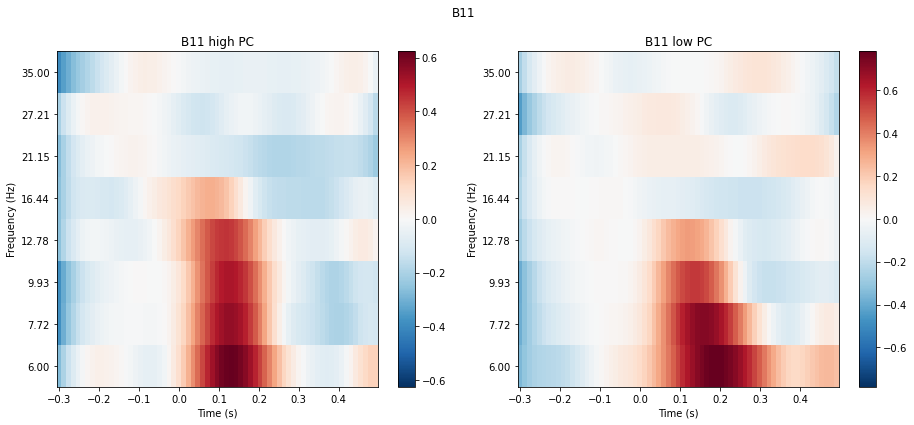

In [16]:
# Plot the power at one electrode
blMode = 'logratio'
figch, axis = plt.subplots(1, 2, figsize=(13, 6))
power_high.plot([pick], baseline=(-0.2, 0), mode=blMode, axes=axis[0], show=False)
power_low.plot([pick], baseline=(-0.2, 0), mode=blMode, axes=axis[1], show=False)
axis[0].set(title=power_high.ch_names[pick] + ' high PC')
axis[1].set(title=power_high.ch_names[pick] + ' low PC')
mne.viz.tight_layout()
plt.show();

## left: high phase coherene. right: low phase coherence. 

# Describe
Alright, we now have a plot of the power at the same electrode (B11) which we plotted ERPs for above.  The plot on the left is high stimuli PC and the right is low stimuli PC.
- **latency**: A bit before on the left? almost instantaneous. 
- **bands**: a bit more extension into higher bands on left. A bit more extremely high on the right. 
- **strength**: Not a big difference.
- **duration**: Somewhat longer in the low frequencies of the right plot. 

Let's broaden our focus but now with the knowledge we got from the above plots

induced/total power vs. evoked.
evoked: ERP, power caused by onset of stimuli (phase-sensitive). locked to a time-point (ERP) and we are interested in the phase. Related to ITC. Alignment of oscillations at different frequencies. What is the power of the oscillatory response. 
induced: Resulting overall power existing within epoch. (non phase-locked activity). We take the square (so we loose negative/positive). 
power spectrum density represents both evoked (the point) and induced is the whole thing (ish)?

for power/signal we need it to be averaged over trials with phase-locking. 


Applying baseline correction (mode: logratio)
Applying baseline correction (mode: logratio)
Applying baseline correction (mode: logratio)
Applying baseline correction (mode: logratio)


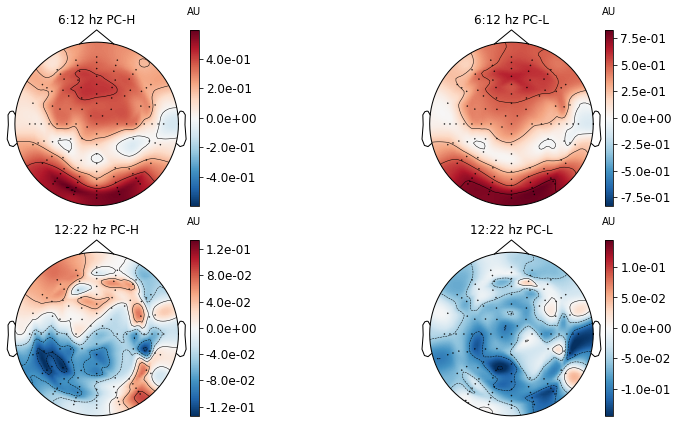

In [17]:
# general definitions
bl, ch = (-0.2, 0), 'eeg' #bl = baseline. 

# relevant to the above plots definitions
fmin1, fmax1, fmin2, fmax2, tmin, tmax = 6, 12, 12, 22, .05, .35

fig, axis = plt.subplots(2, 2, figsize=(13, 6))
power_high.plot_topomap(ch_type=ch, tmin=tmin, tmax=tmax, fmin=fmin1, fmax=fmax1,
                   baseline=bl, mode=blMode, axes=axis[0, 0],
                   title=str(fmin1) + ':' + str(fmax1) + ' hz PC-H', show=False)
power_high.plot_topomap(ch_type='eeg', tmin=tmin, tmax=tmax, fmin=fmin2, fmax=fmax2,
                   baseline=bl, mode=blMode, axes=axis[1, 0],
                   title=str(fmin2) + ':' + str(fmax2) + ' hz PC-H', show=False)
power_low.plot_topomap(ch_type='eeg', tmin=tmin, tmax=tmax, fmin=fmin1, fmax=fmax1,
                   baseline=bl, mode=blMode, axes=axis[0, 1],
                   title=str(fmin1) + ':' + str(fmax1) + ' hz PC-L', show=False)
power_low.plot_topomap(ch_type='eeg', tmin=tmin, tmax=tmax, fmin=fmin2, fmax=fmax2,
                   baseline=bl, mode=blMode, axes=axis[1, 1],
                   title=str(fmin2) + ':' + str(fmax2) + ' hz PC-L', show=False)
mne.viz.tight_layout()
plt.show();

## left = low phase coherence, right = high phase coherence. 

# Describe
What have we got? can you come up with any other frequency combinations that are interesting?
6, 8, 15, 25, 0.05, 0.35
## Investigating further with ITC
Power can only tell us so much, maybe can we get a fuller explanation of the data using ITC?
Let's begin the same way we did above with power and plot the ITC at B11 and the power again for comparison's sake.

## NB
To derive ITC we convert our Fourier coefficients to phase angles. To convert to phase angles we set the magnitude to 1 and locate them on the unit circle. I can draw a polar plot (if necessary) that shows the position of each of the phase angles on the unit circle at single point for each trial.

Applying baseline correction (mode: zscore)
Applying baseline correction (mode: zscore)
Applying baseline correction (mode: zscore)
Applying baseline correction (mode: zscore)


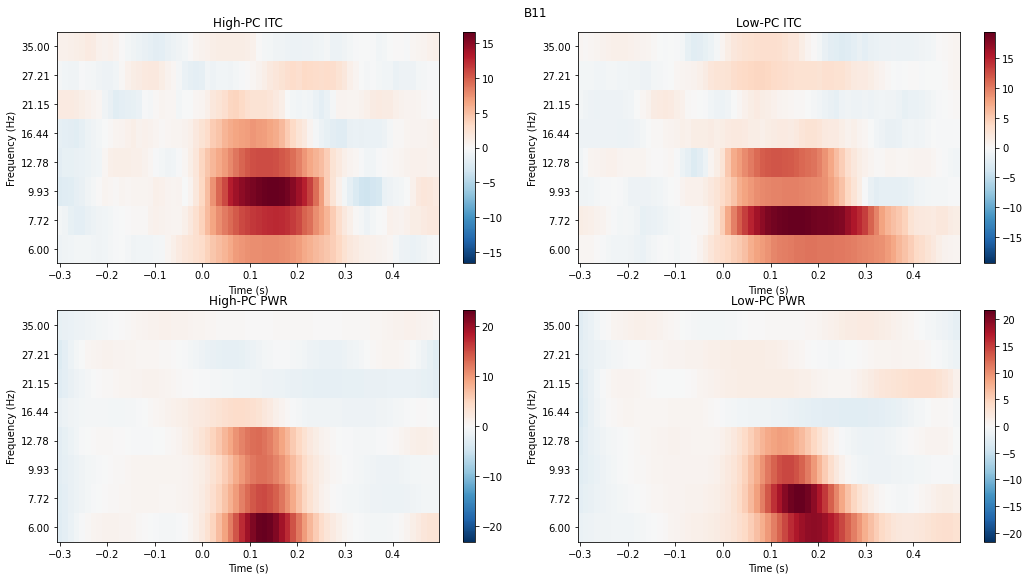

In [38]:
blMode = 'zscore'
fig, axis = plt.subplots(2, 2, figsize=(15, 8))
itc_high.plot(pick, baseline=(-0.3, -0.01), mode=blMode, axes=axis[0,0], show=False);
itc_low.plot(pick, baseline=(-0.3, -0.01), mode=blMode, axes=axis[0,1], show=False);
mne.viz.tight_layout()
axis[0,0].set(title='High-PC ITC')
axis[0,1].set(title='Low-PC ITC')

power_low.plot(pick, baseline=(-0.3, -0.01), mode=blMode, axes=axis[1,1], show=False);
power_high.plot(pick, baseline=(-0.3, -0.01), mode=blMode, axes=axis[1,0], show=False);

axis[1,1].set(title='Low-PC PWR')
axis[1,0].set(title='High-PC PWR')
plt.show();


In [37]:
?itc_high.plot

# Describe
Alright, we now have a plot of the ITC at our old friend B11 and the power again. What's changed?

- latency: faster/stronger in high-beta/low-gamma in Low-PC. 
- bands: 
- strength: 
- duration: longer processing of harder (low-PC) stimuli (in lower bands). 

Why the difference?  What is ITC telling us as compared to power?
Think about and show what these ITC plots tell us about stimuli phase coherence and what's going on in the brain.

# Explore 
From here on out you can use MNE plotting tools to check other things about the effect:
- Check to see if this holds across electrodes or is region dependent
- Timing/Latency
- Bands

In [25]:
# Mess around with the baseline method later ('mean','zscore','ratio','zlogratio' )
# blMode = 'zscore'
# Nice regexp trick with MNE and channels
picks = mne.pick_channels_regexp(itc_high.ch_names, '^B1.') #caret and wildcard. 
# but for this let's just two (can't be one) for demo
picks = [36, 37]

Applying baseline correction (mode: logratio)
Applying baseline correction (mode: logratio)
Applying baseline correction (mode: logratio)


/home/victormp/anaconda3/envs/acn/lib/python3.8/site-packages/mne/baseline.py:102: RuntimeWarning: invalid value encountered in log10
  np.log10(d, out=d)


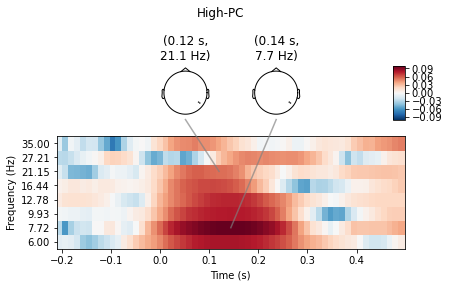

Applying baseline correction (mode: logratio)
Applying baseline correction (mode: logratio)
Applying baseline correction (mode: logratio)


/home/victormp/anaconda3/envs/acn/lib/python3.8/site-packages/mne/baseline.py:102: RuntimeWarning: invalid value encountered in log10
  np.log10(d, out=d)


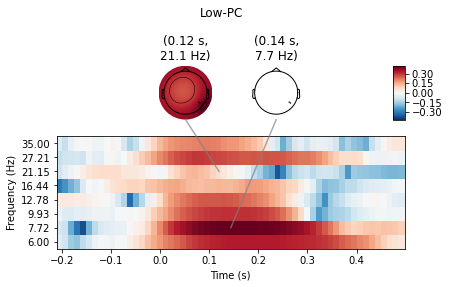

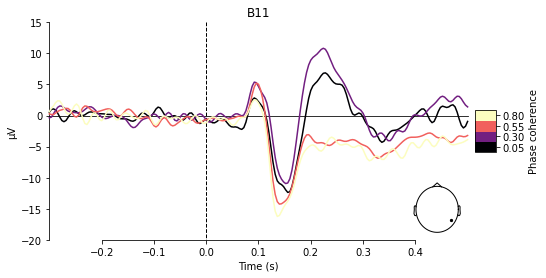

In [26]:
# The baseline method we've been using 'logratio' doesn't play well with joint
# Other methods for baslining should be used to get out topomaps.
## NB: get back and change baseline mode (e.g. z-score) ## 
itc_high.plot_joint(baseline=(-0.3, -0.001), mode=blMode, tmin=-.2, tmax=0.5,
                 timefreqs=[(.12, 21), (.14, 7.5)], picks=picks, title='High-PC');
itc_low.plot_joint(baseline=(-0.3, -0.001), mode=blMode, tmin=-.2, tmax=0.5,
                 timefreqs=[(.12, 21), (.14, 7.5)], picks=picks, title='Low-PC');


# create dict of evokeds for each level of phase-coherence
evokeds = {label: limo_epochs[phase_coh == level].average()
           for level, label in zip(levels[1::5], labels[1::5])}

# pick channel to plot
electrodes = ['B11']
# create figures
for electrode in electrodes:
    fig, ax = plt.subplots(figsize=(8, 4))
    plot_compare_evokeds(evokeds,
                         axes=ax,
                         ylim=dict(eeg=(-20, 15)),
                         picks=electrode,
                         cmap=("Phase coherence", "magma"))

# Compare the ERP and the ITC plots
Think about evoked and induced

# In class
- Find a better electrodes to exemplify what we see
- Think/Show what the ITC for mid PC (when a face becomes discernable - the cut-off) in stimuli would look like
- Change the baseline method: changed from logratio to z-score (more conservative - smaller blobs)

# HW
Your work for over the break (yeah that's right, welcome to the big leaguges) is to give me a a testable hypothesis as to the relationship between ITC and stimuli phase coherence.

In [ ]:
## HW: ?